In [1]:
import numpy as np
import requests
import os
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import mdtraj as md
import nglview as nv

# Working with the Kirchoff matrix of the Gaussian Network Model

## Downloading any PDB file

Let's first of all store the PDB id we want to download and the path where the file needs to be located:

In [2]:
pdb_id = '1HIV'
download_path = "./"

And now let's define an auxiliary function to download pdb files to be stored locally in our machine.

In [3]:
def fetch_pdb(pdb_id, download_path="./"):
        url = 'http://files.rcsb.org/download/{}.pdb'.format(pdb_id)
        try:
            res = requests.get(url, allow_redirects=True)
        except:
            print("Could not fetch pdb from {}".format(url))
            return 
        
        file_path = os.path.join(download_path, pdb_id + ".pdb")
        with open(file_path, "wb") as f:
            f.write(res.content)
        print(f"The {pdb_id} file was downloaded succesfully!")

Time to try it!

In [4]:
fetch_pdb(pdb_id, download_path=download_path)

The 1HIV file was downloaded succesfully!


## Parsing the positions of the CA atoms

We are going take an approach not very short and efficiente to obtain the coordinates of the CA atoms. But let's do it this way just once:

In [5]:
file_path = os.path.join(download_path, pdb_id + ".pdb")

CA_coordinates = []

with open(file_path) as fff:
    for line in fff.readlines():
        if line.startswith('ATOM  ') and line.split()[2]=='CA' :
          
            x, y, z = line.split()[6:9]
            CA_coordinates.append([float(x), float(y), float(z)])

Ok, `CA_coordinates` is a list of lists... let's convert it to a numpy array:

In [6]:
CA_coordinates = np.array(CA_coordinates)

## Defining the Kirchhoff matrix

In [7]:
def kirchhoff_matrix(CA, threshold):
    num_CAs = CA.shape[0]
    matrix = np.zeros((num_CAs, num_CAs), dtype=int)
    for ii in range(num_CAs):
        for jj in range(ii):
            rij=CA[ii]-CA[jj]
            distance=np.sqrt(np.dot(rij,rij))
            if distance<threshold:
                matrix[ii,jj] = -1
                matrix[jj,ii] = -1
                matrix[ii,ii] += 1
                matrix[jj,jj] += 1
    return matrix

In [8]:
K_matrix = kirchhoff_matrix(CA_coordinates, 9.0)

## Diagonalizing from its eigenvalues

In [9]:
eigenvals, eigenvects = eigh(K_matrix)

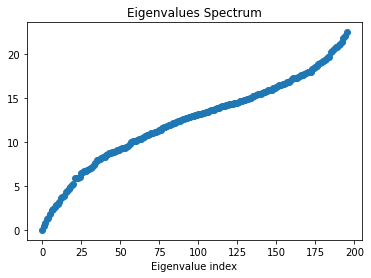

In [10]:
num_modes = eigenvals.shape[0]

plt.scatter(range(num_modes), eigenvals)
plt.title('Eigenvalues Spectrum')
plt.xlabel('Eigenvalue index')
plt.show()

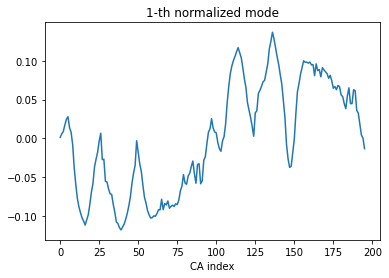

In [21]:
mode_index = 1
plt.plot(range(num_modes), eigenvects[:,mode_index])
plt.title(f'{mode_index}-th normalized mode')
plt.xlabel('CA index')
plt.show()

# The fluctuation contribution of each mode over the protein

In [39]:
traj = md.load(file_path)

In [47]:
atoms_in_protein = traj.topology.select('chainid 0 1')

In [48]:
traj_protein = traj.atom_slice(atoms_in_protein)

In [49]:
nv.show_mdtraj(traj_protein)

NGLWidget()